In [5]:
# Basis-Bibliotheken für Datenverarbeitung
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Transformer für Sentiment-Analyse
from transformers import pipeline

print("Setup abgeschlossen!")
print(f"Pandas Version: {pd.__version__}")
print(f"NumPy Version: {np.__version__}")


Setup abgeschlossen!
Pandas Version: 2.3.0+4.g1dfc98e16a
NumPy Version: 2.0.2


In [6]:
# Tweets laden
print("Lade Tweet-Daten...")
tweets_df = pd.read_csv('stock_tweets.csv')
print(f"Tweet-Datensatz: {tweets_df.shape[0]} Zeilen, {tweets_df.shape[1]} Spalten")

# Aktienkurse laden
print("Lade Aktienkurs-Daten...")
stock_df = pd.read_csv('stock_yfinance_data.csv')
print(f"Aktienkurs-Datensatz: {stock_df.shape[0]} Zeilen, {stock_df.shape[1]} Spalten")

# Erste Einblicke
print("\n=== Tweet-Daten ===")
print(tweets_df.head())
print("\nVerfügbare Aktien in Tweets:", tweets_df['Stock Name'].unique())

print("\n=== Aktienkurs-Daten ===")
print(stock_df.head())
print("\nVerfügbare Aktien in Kursdaten:", stock_df['Stock Name'].unique())


Lade Tweet-Daten...
Tweet-Datensatz: 80793 Zeilen, 4 Spalten
Lade Aktienkurs-Daten...
Aktienkurs-Datensatz: 6300 Zeilen, 8 Spalten

=== Tweet-Daten ===
                        Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.  

Verfügbare Aktien in Tweets: ['TSLA' 'MSFT' 'PG' 'META' 'AMZN' 'GOOG' 'AMD' 'AAPL' 'NFLX' 'TSM' 'KO'
 'F' 'COST' 'DIS' 'VZ' 'CRM' 'INTC' 'BA' 'BX' 'NOC' 'PYPL' 'ENPH' 'NIO'
 'ZS' '

In [7]:
# Datum-Spalten konvertieren
print("Konvertiere Datumsangaben...")

# Tweets: Datum konvertieren und nur das Datum (ohne Uhrzeit) extrahieren
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'], errors='coerce')
tweets_df['Date_only'] = tweets_df['Date'].dt.date

# Aktienkurse: Datum konvertieren
stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce')
stock_df['Date_only'] = stock_df['Date'].dt.date

# Fehlende Werte entfernen
tweets_df.dropna(subset=['Date', 'Tweet', 'Stock Name'], inplace=True)
stock_df.dropna(subset=['Date', 'Close', 'Stock Name'], inplace=True)

print(f"Nach Bereinigung - Tweets: {tweets_df.shape[0]} Zeilen")
print(f"Nach Bereinigung - Aktienkurse: {stock_df.shape[0]} Zeilen")

# Zeitraum der Daten anzeigen
print(f"\nTweets Zeitraum: {tweets_df['Date'].min()} bis {tweets_df['Date'].max()}")
print(f"Aktienkurse Zeitraum: {stock_df['Date'].min()} bis {stock_df['Date'].max()}")


Konvertiere Datumsangaben...
Nach Bereinigung - Tweets: 80793 Zeilen
Nach Bereinigung - Aktienkurse: 6300 Zeilen

Tweets Zeitraum: 2021-09-30 00:06:02+00:00 bis 2022-09-29 23:41:16+00:00
Aktienkurse Zeitraum: 2021-09-30 00:00:00 bis 2022-09-29 00:00:00


Führe Sentiment-Analyse durch...
Sentiment-Analyse abgeschlossen!
Durchschnittlicher Sentiment-Score: 0.1760
Sentiment-Score Bereich: -0.9911 bis 0.9925


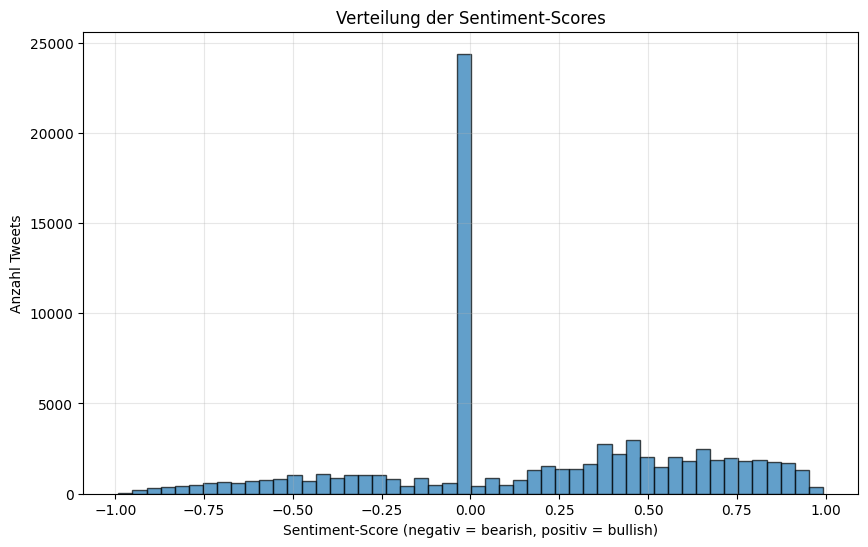

In [8]:
# Für die Demo verwenden wir VADER (schneller als Transformer)
# In der Produktion würden Sie FinBERT oder ähnliche Transformer verwenden
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# VADER Lexikon herunterladen
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    nltk.download('vader_lexicon')

# Sentiment Analyzer initialisieren
vader = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    """
    Analysiert das Sentiment eines Textes mit VADER
    Gibt compound score zurück (-1 bis +1)
    """
    try:
        scores = vader.polarity_scores(str(text))
        return scores['compound']
    except:
        return 0.0

# Sentiment-Analyse auf Tweets anwenden
print("Führe Sentiment-Analyse durch...")
tweets_df['sentiment_score'] = tweets_df['Tweet'].apply(analyze_sentiment)

print(f"Sentiment-Analyse abgeschlossen!")
print(f"Durchschnittlicher Sentiment-Score: {tweets_df['sentiment_score'].mean():.4f}")
print(f"Sentiment-Score Bereich: {tweets_df['sentiment_score'].min():.4f} bis {tweets_df['sentiment_score'].max():.4f}")

# Verteilung visualisieren
plt.figure(figsize=(10, 6))
plt.hist(tweets_df['sentiment_score'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Verteilung der Sentiment-Scores')
plt.xlabel('Sentiment-Score (negativ = bearish, positiv = bullish)')
plt.ylabel('Anzahl Tweets')
plt.grid(True, alpha=0.3)
plt.show()


In [9]:
# Technische Indikatoren für jede Aktie berechnen
def calculate_technical_indicators(df):
    """
    Berechnet technische Indikatoren für einen DataFrame mit Aktienkursen
    """
    df = df.copy()
    df = df.sort_values('Date').reset_index(drop=True)
    
    # RSI (Relative Strength Index)
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.rolling(window=window, min_periods=window).mean()
        avg_loss = loss.rolling(window=window, min_periods=window).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    # Moving Averages
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    
    # RSI
    df['RSI'] = calculate_rsi(df['Close'])
    
    # Bollinger Bands
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    df['BB_std'] = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + (df['BB_std'] * 2)
    df['BB_lower'] = df['BB_middle'] - (df['BB_std'] * 2)
    
    # Price relative to Bollinger Bands
    df['BB_position'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])
    
    # Volume indicators
    df['Volume_MA'] = df['Volume'].rolling(window=20).mean()
    df['Volume_ratio'] = df['Volume'] / df['Volume_MA']
    
    # Price change indicators
    df['Price_change'] = df['Close'].pct_change()
    df['Price_change_5d'] = df['Close'].pct_change(periods=5)
    
    return df

# Technische Indikatoren für jede Aktie berechnen
print("Berechne technische Indikatoren...")
stock_with_indicators = []

for stock in stock_df['Stock Name'].unique():
    stock_data = stock_df[stock_df['Stock Name'] == stock].copy()
    stock_data_with_indicators = calculate_technical_indicators(stock_data)
    stock_with_indicators.append(stock_data_with_indicators)

# Alle Aktien wieder zusammenfügen
stock_df_enhanced = pd.concat(stock_with_indicators, ignore_index=True)

print(f"Technische Indikatoren berechnet für {stock_df_enhanced['Stock Name'].nunique()} Aktien")
print(f"Neue Spalten: {[col for col in stock_df_enhanced.columns if col not in stock_df.columns]}")

# Erste Zeilen mit Indikatoren anzeigen
print("\nErste Zeilen mit technischen Indikatoren:")
print(stock_df_enhanced[['Date', 'Stock Name', 'Close', 'RSI', 'MA_5', 'MA_20', 'BB_position']].head(10))


Berechne technische Indikatoren...
Technische Indikatoren berechnet für 25 Aktien
Neue Spalten: ['MA_5', 'MA_20', 'RSI', 'BB_middle', 'BB_std', 'BB_upper', 'BB_lower', 'BB_position', 'Volume_MA', 'Volume_ratio', 'Price_change', 'Price_change_5d']

Erste Zeilen mit technischen Indikatoren:
        Date Stock Name       Close  RSI        MA_5  MA_20  BB_position
0 2021-09-30       TSLA  258.493347  NaN         NaN    NaN          NaN
1 2021-10-01       TSLA  258.406677  NaN         NaN    NaN          NaN
2 2021-10-04       TSLA  260.510010  NaN         NaN    NaN          NaN
3 2021-10-05       TSLA  260.196655  NaN         NaN    NaN          NaN
4 2021-10-06       TSLA  260.916656  NaN  259.704669    NaN          NaN
5 2021-10-07       TSLA  264.536682  NaN  260.913336    NaN          NaN
6 2021-10-08       TSLA  261.829987  NaN  261.597998    NaN          NaN
7 2021-10-11       TSLA  263.980011  NaN  262.291998    NaN          NaN
8 2021-10-12       TSLA  268.573334  NaN  263.967334 

In [10]:
# Tweet-Sentiment pro Tag und Aktie aggregieren
print("Aggregiere Tweet-Sentiment-Daten...")

# Tweets pro Tag und Aktie zusammenfassen
tweet_daily = tweets_df.groupby(['Date_only', 'Stock Name']).agg({
    'sentiment_score': ['mean', 'std', 'count'],
    'Tweet': 'count'
}).reset_index()

# Spalten umbenennen
tweet_daily.columns = ['Date_only', 'Stock Name', 'sentiment_mean', 'sentiment_std', 'sentiment_count', 'tweet_count']

# NaN-Werte für Standardabweichung durch 0 ersetzen (wenn nur ein Tweet pro Tag)
tweet_daily['sentiment_std'] = tweet_daily['sentiment_std'].fillna(0)

print(f"Tweet-Daten aggregiert: {tweet_daily.shape[0]} Zeilen")
print("Erste Zeilen der aggregierten Tweet-Daten:")
print(tweet_daily.head())

# Aktienkurs-Daten mit Ziel-Variable erweitern
print("\nErstelle Ziel-Variable (nächster Tag steigt/fällt)...")

# Für jede Aktie die Ziel-Variable berechnen
stock_with_target = []

for stock in stock_df_enhanced['Stock Name'].unique():
    stock_data = stock_df_enhanced[stock_df_enhanced['Stock Name'] == stock].copy()
    stock_data = stock_data.sort_values('Date').reset_index(drop=True)
    
    # Ziel-Variable: Steigt der Kurs am nächsten Tag?
    stock_data['next_day_close'] = stock_data['Close'].shift(-1)
    stock_data['price_up_tomorrow'] = (stock_data['next_day_close'] > stock_data['Close']).astype(int)
    
    stock_with_target.append(stock_data)

stock_df_final = pd.concat(stock_with_target, ignore_index=True)

# Letzte Zeile entfernen (kein nächster Tag verfügbar)
stock_df_final = stock_df_final.dropna(subset=['next_day_close'])

print(f"Aktienkurs-Daten mit Ziel-Variable: {stock_df_final.shape[0]} Zeilen")
print(f"Verteilung Ziel-Variable: {stock_df_final['price_up_tomorrow'].value_counts()}")

# Daten zusammenführen
print("\nFühre Tweet- und Aktienkurs-Daten zusammen...")

# Merge auf Datum und Aktie
final_df = pd.merge(
    stock_df_final,
    tweet_daily,
    on=['Date_only', 'Stock Name'],
    how='left'
)

print(f"Zusammengeführter Datensatz: {final_df.shape[0]} Zeilen, {final_df.shape[1]} Spalten")

# Fehlende Tweet-Daten mit 0 füllen (Tage ohne Tweets)
sentiment_cols = ['sentiment_mean', 'sentiment_std', 'sentiment_count', 'tweet_count']
final_df[sentiment_cols] = final_df[sentiment_cols].fillna(0)

print(f"Nach Auffüllen fehlender Werte: {final_df.shape[0]} Zeilen")
print("\nErste Zeilen des finalen Datensatzes:")
print(final_df[['Date', 'Stock Name', 'Close', 'RSI', 'sentiment_mean', 'tweet_count', 'price_up_tomorrow']].head())


Aggregiere Tweet-Sentiment-Daten...
Tweet-Daten aggregiert: 5910 Zeilen
Erste Zeilen der aggregierten Tweet-Daten:
    Date_only Stock Name  sentiment_mean  sentiment_std  sentiment_count  \
0  2021-09-30       AAPL         0.09890       0.319659                7   
1  2021-09-30        AMD         0.41780       0.422632                6   
2  2021-09-30       AMZN         0.24648       0.597336                5   
3  2021-09-30        DIS         0.54610       0.000000                1   
4  2021-09-30       GOOG         0.44040       0.000000                1   

   tweet_count  
0            7  
1            6  
2            5  
3            1  
4            1  

Erstelle Ziel-Variable (nächster Tag steigt/fällt)...
Aktienkurs-Daten mit Ziel-Variable: 6275 Zeilen
Verteilung Ziel-Variable: price_up_tomorrow
0    3251
1    3024
Name: count, dtype: int64

Führe Tweet- und Aktienkurs-Daten zusammen...
Zusammengeführter Datensatz: 6275 Zeilen, 27 Spalten
Nach Auffüllen fehlender Werte: 6

Bereite Daten für Machine Learning vor...
Datensatz für ML: 5800 Zeilen
Features: ['RSI', 'MA_5', 'MA_20', 'BB_position', 'Volume_ratio', 'Price_change', 'Price_change_5d', 'sentiment_mean', 'sentiment_std', 'tweet_count']
Feature-Matrix: (5800, 10)
Ziel-Variable: (5800,)
Klassen-Verteilung: price_up_tomorrow
0    3060
1    2740
Name: count, dtype: int64

Trainingsdaten: 4640 Zeilen
Testdaten: 1160 Zeilen

Trainiere Random Forest Modell...

Modell-Genauigkeit: 0.5276

Detaillierter Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.54      0.68      0.61       616
           1       0.49      0.35      0.41       544

    accuracy                           0.53      1160
   macro avg       0.52      0.52      0.51      1160
weighted avg       0.52      0.53      0.51      1160



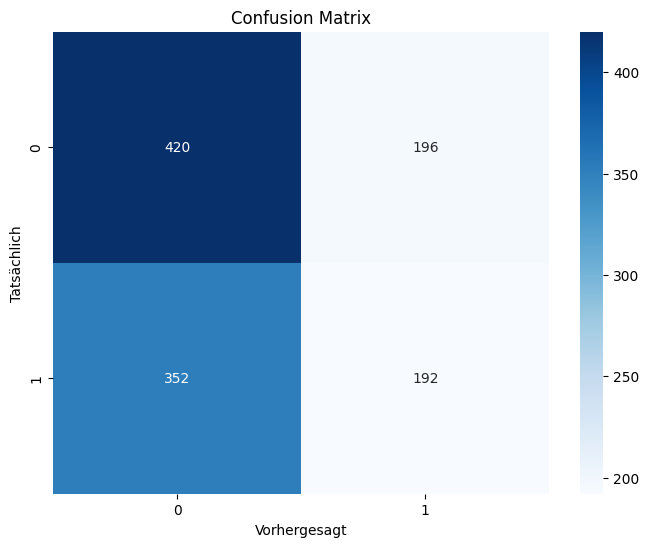

In [11]:
# Features für das Modell auswählen
print("Bereite Daten für Machine Learning vor...")

# Feature-Spalten definieren
feature_columns = [
    'RSI', 'MA_5', 'MA_20', 'BB_position', 'Volume_ratio',
    'Price_change', 'Price_change_5d',
    'sentiment_mean', 'sentiment_std', 'tweet_count'
]

# Nur Zeilen mit allen Features verwenden (keine NaN-Werte)
ml_df = final_df.dropna(subset=feature_columns + ['price_up_tomorrow'])

print(f"Datensatz für ML: {ml_df.shape[0]} Zeilen")
print(f"Features: {feature_columns}")

# Features und Ziel-Variable extrahieren
X = ml_df[feature_columns]
y = ml_df['price_up_tomorrow']

print(f"Feature-Matrix: {X.shape}")
print(f"Ziel-Variable: {y.shape}")
print(f"Klassen-Verteilung: {y.value_counts()}")

# Daten in Training und Test aufteilen (zeitlich sortiert)
# Verwende die ersten 80% für Training, die letzten 20% für Test
split_idx = int(len(ml_df) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"\nTrainingsdaten: {X_train.shape[0]} Zeilen")
print(f"Testdaten: {X_test.shape[0]} Zeilen")

# Features skalieren
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Modell trainieren
print("\nTrainiere Random Forest Modell...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  # Für unbalancierte Klassen
)

rf_model.fit(X_train_scaled, y_train)

# Vorhersagen auf Testdaten
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Modell-Performance evaluieren
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModell-Genauigkeit: {accuracy:.4f}")

print("\nDetaillierter Klassifikationsbericht:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Vorhergesagt')
plt.ylabel('Tatsächlich')
plt.show()


Feature-Wichtigkeit:
           feature  importance
6  Price_change_5d    0.145519
5     Price_change    0.119066
4     Volume_ratio    0.116939
3      BB_position    0.110634
0              RSI    0.109221
2            MA_20    0.099614
1             MA_5    0.092224
7   sentiment_mean    0.090514
8    sentiment_std    0.061499
9      tweet_count    0.054770


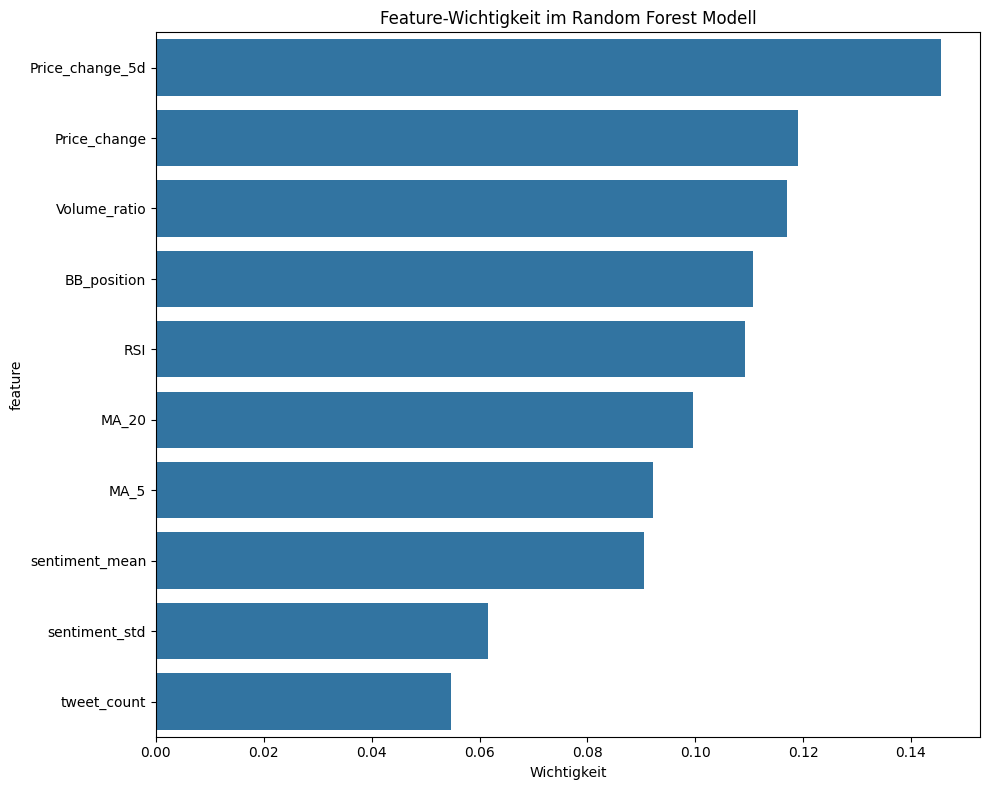

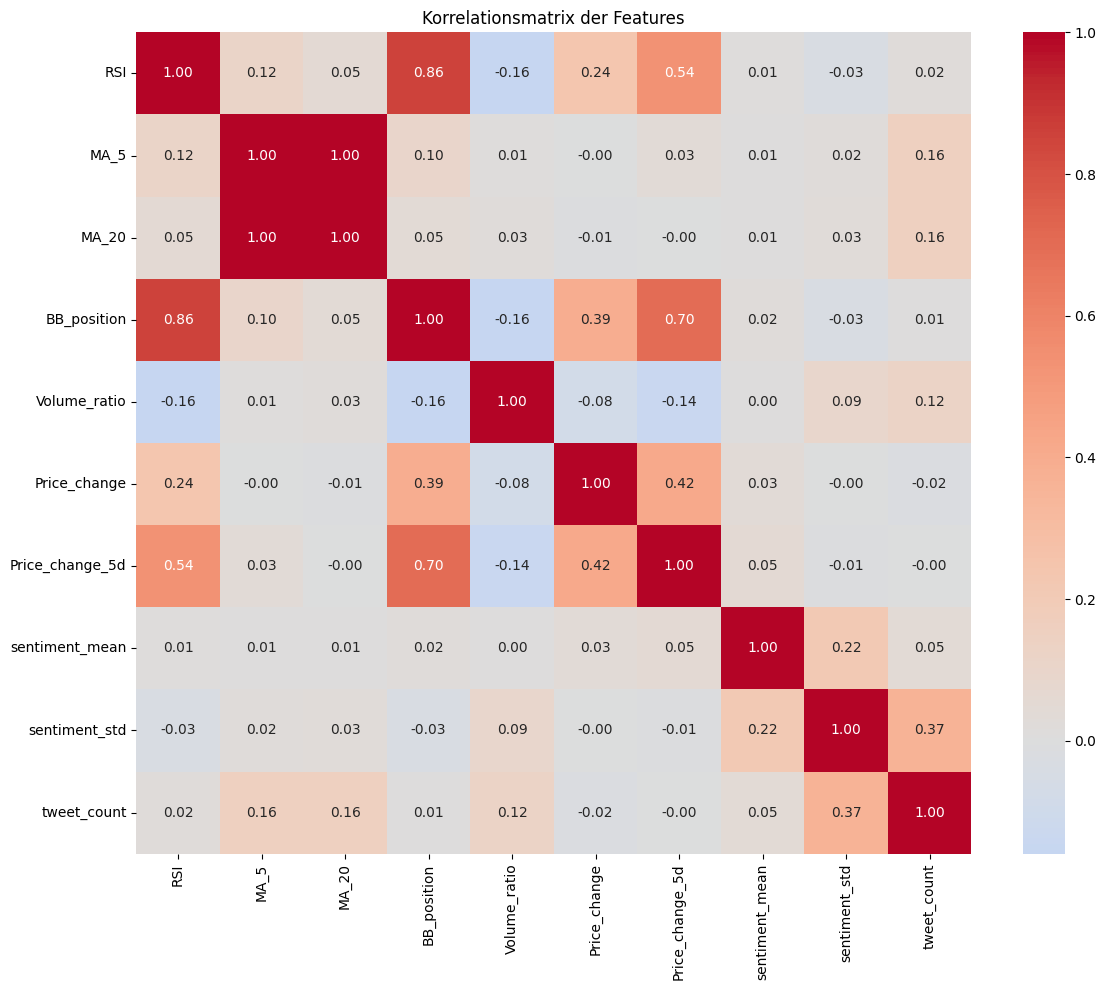


Modell-Performance pro Aktie:
PYPL: 0.5517 (232 Tage)
ENPH: 0.5043 (232 Tage)
NIO: 0.5431 (232 Tage)
ZS: 0.5345 (232 Tage)
XPEV: 0.5043 (232 Tage)

Beispiel-Vorhersagen (letzte 10 Tage):
           Date Stock Name  Close  sentiment_mean        RSI  \
6265 2022-09-15       XPEV  15.51          0.0000  18.152358   
6266 2022-09-16       XPEV  14.56          0.0000  16.969706   
6267 2022-09-19       XPEV  15.64          0.3818  30.261353   
6268 2022-09-20       XPEV  15.93          0.0000  34.062931   
6269 2022-09-21       XPEV  14.09          0.0000  25.084366   
6270 2022-09-22       XPEV  13.74          0.0000  27.701866   
6271 2022-09-23       XPEV  13.71          0.0000  29.773034   
6272 2022-09-26       XPEV  14.37          0.5859  39.534886   
6273 2022-09-27       XPEV  13.71          0.0000  35.451080   
6274 2022-09-28       XPEV  13.33          0.0000  35.541399   

      price_up_tomorrow  predicted  prediction_proba  
6265                  0          0          0.455823

In [12]:
# Feature-Wichtigkeit analysieren
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature-Wichtigkeit:")
print(feature_importance)

# Feature-Wichtigkeit visualisieren
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature-Wichtigkeit im Random Forest Modell')
plt.xlabel('Wichtigkeit')
plt.tight_layout()
plt.show()

# Korrelationsmatrix der Features
plt.figure(figsize=(12, 10))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Korrelationsmatrix der Features')
plt.tight_layout()
plt.show()

# Modell-Performance pro Aktie analysieren
print("\nModell-Performance pro Aktie:")
test_results = ml_df.iloc[split_idx:].copy()
test_results['predicted'] = y_pred
test_results['prediction_proba'] = y_pred_proba

for stock in test_results['Stock Name'].unique():
    stock_data = test_results[test_results['Stock Name'] == stock]
    if len(stock_data) > 10:  # Nur Aktien mit genügend Testdaten
        stock_accuracy = accuracy_score(stock_data['price_up_tomorrow'], stock_data['predicted'])
        print(f"{stock}: {stock_accuracy:.4f} ({len(stock_data)} Tage)")

# Beispiel-Vorhersagen anzeigen
print("\nBeispiel-Vorhersagen (letzte 10 Tage):")
example_predictions = test_results[['Date', 'Stock Name', 'Close', 'sentiment_mean', 'RSI', 
                                  'price_up_tomorrow', 'predicted', 'prediction_proba']].tail(10)
print(example_predictions)
